### Comments, links

https://github.com/deepset-ai/FARM/blob/master/examples/dpr_encoder.py
hur dpr byggs

https://colab.research.google.com/drive/1h65P_aqKZRpgFUOqkwYDNHOoVv9fvslg?usp=sharing
colab på exempel för en dpr med annat än bert

https://www.pragmatic.ml/language-modeling-and-retrieval/
gör om dpr tabellen

https://www.programmersought.com/article/23924708503/
gör om dpr tabellen med olika datamängder

https://github.com/huggingface/transformers/issues/5816
bert lägg till lager

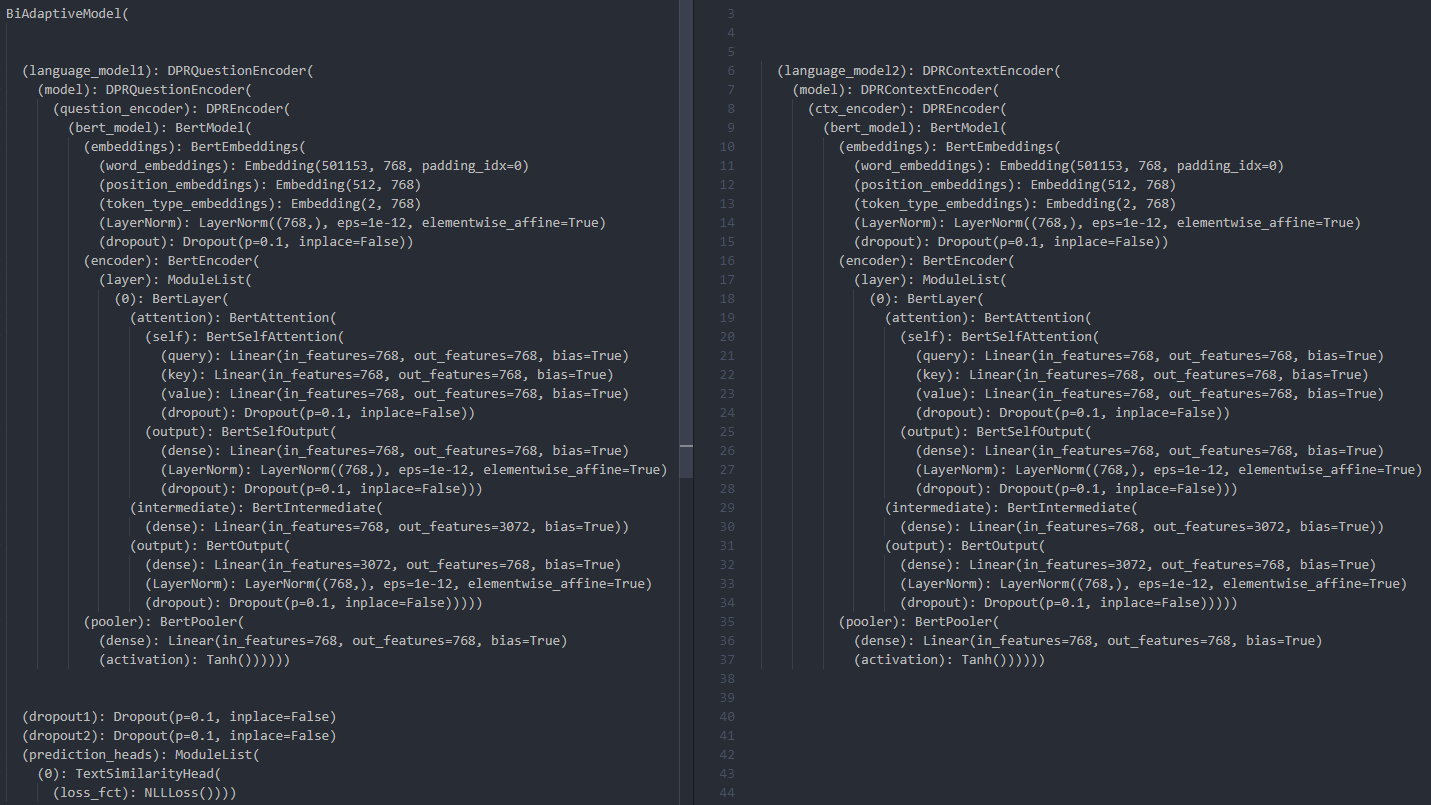



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# pre-imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG
import os
import psutil
import torch, gc

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mexdpr/psgs_w100.tsv
/kaggle/input/mexdpr/nq-test.qa.csv
/kaggle/input/mexdpr/small/nq-train.json
/kaggle/input/mexdpr/small/nq-dev.json
/kaggle/input/mexdpr/small/nq-test.json
/kaggle/input/mexdpr/small/da01f2d71bc0608fa6323710eaabaf94/test_dataset
/kaggle/input/mexdpr/small/da01f2d71bc0608fa6323710eaabaf94/tensor_names
/kaggle/input/mexdpr/small/da01f2d71bc0608fa6323710eaabaf94/train_dataset
/kaggle/input/mexdpr/small/da01f2d71bc0608fa6323710eaabaf94/dev_dataset
/kaggle/input/mexdpr/fifths/nq-train.json
/kaggle/input/mexdpr/fifths/nq-dev.json
/kaggle/input/mexdpr/fifths/nq-test.json
/kaggle/input/mexdpr/BERT/model/config.json
/kaggle/input/mexdpr/BERT/model/pytorch_model.bin
/kaggle/input/mexdpr/BERT/tokenizer/tokenizer_config.json
/kaggle/input/mexdpr/BERT/tokenizer/special_tokens_map.json
/kaggle/input/mexdpr/BERT/tokenizer/vocab.txt
/kaggle/input/mexdpr/BERT/config/config.json
/kaggle/input/mexdpr/fifths_saved_run_labse/prediction_head_0.bin
/kaggle/input/mexdpr/fift

In [2]:
def create_logger(exp_version):
    log_file = ("{}.log".format(exp_version))

    # logger
    logger_ = getLogger(exp_version)
    logger_.setLevel(0)

    # formatter
    fmr = Formatter("[%(levelname)s] %(asctime)s >>\t%(message)s")

    # file handler
    fh = FileHandler(log_file)
    fh.setLevel(DEBUG)
    fh.setFormatter(fmr)

    # stream handler
    ch = StreamHandler()
    ch.setLevel(INFO)
    ch.setFormatter(fmr)

    logger_.addHandler(fh)
    logger_.addHandler(ch)

def get_logger(exp_version):
    return getLogger(exp_version)

VERSION = "001" # 実験番号
create_logger(VERSION)
logger = get_logger(VERSION)

In [3]:
!nvidia-smi

Wed May  5 18:21:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#print gpu memory usage
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0]/2.**30  # memory use in GB
print('memory use:', memoryUse)

memory use: 0.2984809875488281


In [5]:
torch.cuda.is_available()

True

In [6]:
# clear shit
gc.collect()
torch.cuda.empty_cache()

In [7]:
%%capture
!pip install git+https://github.com/deepset-ai/FARM.git
!pip install git+https://github.com/deepset-ai/haystack.git
!pip install git+https://github.com/huggingface/transformers

In [8]:
!pip freeze > requirements.txt

In [9]:
#IMPORTS

#from typing import List, Union, Optional
from tqdm import tqdm

from farm.modeling.tokenization import Tokenizer
from farm.modeling.language_model import LanguageModel
from farm.modeling.biadaptive_model import BiAdaptiveModel
from farm.modeling.prediction_head import TextSimilarityHead
from farm.data_handler.processor import TextSimilarityProcessor
from farm.data_handler.data_silo import DataSilo#, StreamingDataSilo, _StreamingDataSet
from farm.data_handler.dataloader import NamedDataLoader
from farm.modeling.optimization import initialize_optimizer
from farm.train import Trainer

# DPR imports
#from transformers import DPRConfig, AutoConfig
from transformers import DPRQuestionEncoder,DPRQuestionEncoderTokenizer
from transformers import DPRContextEncoder,DPRContextEncoderTokenizer

#from torch.utils.data.sampler import SequentialSampler
from farm.visual.ascii.images import BUSH_SEP
import numbers

import json
import os.path
from os import path
import sys, shutil

In [10]:
data_dirpath = "../input/mexdpr"
size_dirpath = "fifths"
train_filepath = "nq-train.json"
dev_filepath = "nq-dev.json"
test_filepath = "nq-test.json"
save_dirpath = "saved_models"

BERT = False

if BERT:
    tokenizer_path = "../input/mexdpr/BERT/tokenizer"
    model_path = "../input/mexdpr/BERT/model"
    config_path = "../input/mexdpr/BERT/config"
    vocab_size = 30522
else:
    tokenizer_path = "../input/mexdpr/LaBSE-BERT/tokenizer"
    model_path = "../input/mexdpr/LaBSE-BERT/model"
    config_path = "../input/mexdpr/LaBSE-BERT/config"
    vocab_size = 501153

In [11]:
data_dir = os.path.join(data_dirpath, size_dirpath)
train_filename = os.path.join(data_dir, train_filepath)
dev_filename = os.path.join(data_dir,dev_filepath)
test_filename = os.path.join(data_dir,test_filepath)
save_dirname = os.path.join(data_dir, save_dirpath)

In [12]:
# loading tokenizers and models
dpr_tkn_q = DPRQuestionEncoderTokenizer.from_pretrained(
   pretrained_model_name_or_path=str(tokenizer_path),
   tokenizer_class = "DPRQuestionEncoderTokenizer",
   vocab_size = vocab_size)
dpr_mdl_q = LanguageModel.load(
   pretrained_model_name_or_path=str(model_path),
   language_model_class="DPRQuestionEncoder",
   vocab_size = vocab_size)

dpr_tkn_p = DPRContextEncoderTokenizer.from_pretrained(
   pretrained_model_name_or_path=str(tokenizer_path),
   tokenizer_class = "DPRContextEncoderTokenizer",
   vocab_size = vocab_size)
dpr_mdl_p = LanguageModel.load(
   pretrained_model_name_or_path=str(model_path),
   language_model_class="DPRContextEncoder",
   vocab_size = vocab_size)

In [13]:
# Get the dimensions of all of the model's parameters as a list of tuples.
params = list(dpr_mdl_q.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<85} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<85} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<85} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

model.question_encoder.bert_model.embeddings.word_embeddings.weight                   (501153, 768)
model.question_encoder.bert_model.embeddings.position_embeddings.weight                 (512, 768)
model.question_encoder.bert_model.embeddings.token_type_embeddings.weight                 (2, 768)
model.question_encoder.bert_model.embeddings.LayerNorm.weight                               (768,)
model.question_encoder.bert_model.embeddings.LayerNorm.bias                                 (768,)

==== First Transformer ====

model.question_encoder.bert_model.encoder.layer.0.attention.self.query.weight           (768, 768)
model.question_encoder.bert_model.encoder.layer.0.attention.self.query.bias                 (768,)
model.question_encoder.bert_model.encoder.layer.0.attention.self.key.weight             (768, 768)
model.question_encoder.bert_model.encoder.layer.0.attention.self.key.bias                   (768,)

In [14]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

   DPRQuestionEncoderTokenizer:  2.0 KiB
    DPRContextEncoderTokenizer:  2.0 KiB
                        params:  1.8 KiB
            DPRQuestionEncoder:  1.4 KiB
             DPRContextEncoder:  1.4 KiB
                           _i2:  1.3 KiB
                   FileHandler:  1.2 KiB
                 StreamHandler:  1.2 KiB
                           _i1:  1.1 KiB
                     Formatter:  1.0 KiB


In [15]:
# params
param_list = dict(
max_processes = int(1)#128
,dev_split = float(0)
,batch_size = int(2)#16
,max_seq_len_passage = int(256)
,max_seq_len_query = int(64)
,embed_title = bool(True)
,num_hard_negatives = int(1)
,num_positives = int(1)
,n_epochs = int(5)
#,evaluate_every = int(int(training_samples/10)-1) #every 20%
,cp_on_sigterm = bool(True)
,cp_root_dir = str('./checkpoints')
,n_gpu = int(1)
,learning_rate = float(1e-5)
,epsilon = float(1e-08)
,weight_decay = float(0.0)
,num_warmup_steps = int(100)
,grad_acc_steps = int(8)
,optimizer_name = str("TransformersAdamW")
,optimizer_correct_bias = bool(True)
,query_encoder_save_dir = str("query_encoder")
,passage_encoder_save_dir = str("passage_encoder"))

In [16]:
# logging parameters

if BERT:
    logger.info('BERT')
else:
    logger.info('LaBSE-BERT')
    
for p in param_list:
    to_log = f"{p:<20}{param_list[p]:>20}"
    logger.info(to_log)

[INFO] 2021-05-05 18:24:33,666 >>	LaBSE-BERT
[INFO] 2021-05-05 18:24:33,668 >>	max_processes                          1
[INFO] 2021-05-05 18:24:33,669 >>	dev_split                            0.0
[INFO] 2021-05-05 18:24:33,670 >>	batch_size                             2
[INFO] 2021-05-05 18:24:33,671 >>	max_seq_len_passage                  256
[INFO] 2021-05-05 18:24:33,673 >>	max_seq_len_query                     64
[INFO] 2021-05-05 18:24:33,674 >>	embed_title                            1
[INFO] 2021-05-05 18:24:33,675 >>	num_hard_negatives                     1
[INFO] 2021-05-05 18:24:33,676 >>	num_positives                          1
[INFO] 2021-05-05 18:24:33,678 >>	n_epochs                               5
[INFO] 2021-05-05 18:24:33,679 >>	cp_on_sigterm                          1
[INFO] 2021-05-05 18:24:33,680 >>	cp_root_dir                ./checkpoints
[INFO] 2021-05-05 18:24:33,681 >>	n_gpu                                  1
[INFO] 2021-05-05 18:24:33,683 >>	learning_rate        

In [17]:
# instantiate processor
dpr_processor = TextSimilarityProcessor(query_tokenizer=dpr_tkn_q,
                                            passage_tokenizer=dpr_tkn_p,
                                            max_seq_len_passage=param_list['max_seq_len_passage'],
                                            max_seq_len_query=param_list['max_seq_len_query'],
                                            label_list=["hard_negative", "positive"],
                                            metric="text_similarity_metric",
                                            data_dir=Path(data_dir), #"../input/mexdpr/medium",
                                            train_filename=Path(train_filepath), #"nq-train.json",
                                            dev_filename=Path(dev_filepath), #"nq-dev.json",
                                            test_filename=Path(test_filepath), #"nq-test.json",
                                            dev_split=param_list['dev_split'],
                                            embed_title=param_list['embed_title'],
                                            num_hard_negatives=param_list['num_hard_negatives'],
                                            num_positives=param_list['num_positives'])

In [18]:
# instantiate head connection function
dpr_prediction_head = TextSimilarityHead(similarity_function="dot_product")

In [19]:
# instantiate model
dpr_model = BiAdaptiveModel(
            language_model1=dpr_mdl_q,
            language_model2=dpr_mdl_p,
            prediction_heads=[dpr_prediction_head],
            embeds_dropout_prob=0.1,
            lm1_output_types=["per_sequence"],
            lm2_output_types=["per_sequence"],
            device=torch.device("cuda"))

In [20]:
# connect bi-model heads
dpr_model.connect_heads_with_processor(dpr_processor.tasks, require_labels=True)

In [21]:
def get_trainable_p_c():
    # get all parameters set to require gradient computations (all parameters are set to true initially, so this lists all parameters now)
    all_p = []
    rq_gr = []
    not_rq_gr = []

    for name, param in dpr_model.named_parameters():
        all_p.append(name)
        if param.requires_grad:
            rq_gr.append(name)
        else:
            not_rq_gr.append(name)
    
    # get all components set to train
    trainable = []
    not_trainable = []

    for p in all_p:
        components = p.split('.')
        x = []
        cs = []

        for c in components:
            cs.append(c)
            if not x:
                x1 = getattr(dpr_model,c)
                if hasattr(x1,'training'):
                    tr = getattr(x1,'training')
                    if tr:
                        trainable.append('.'.join(cs))
                    else:
                        not_trainable.append('.'.join(cs))
                x.append(x1)
            else:
                x1 = getattr(x[-1],c)
                if hasattr(x1,'training'):
                    tr = getattr(x1,'training')
                    if tr:
                        trainable.append('.'.join(cs))
                    else:
                        not_trainable.append('.'.join(cs))
                x.append(x1)
                
    return rq_gr, not_rq_gr, trainable, not_trainable

In [22]:
trainable_p_c = {}
not_trainable_p_c = {}

rq_gr, not_rq_gr, trainable, not_trainable = get_trainable_p_c()

trainable_p_c['before'] = {'requires_grad': list(dict.fromkeys(rq_gr)),
                           'trainable componets': list(dict.fromkeys(trainable))}
not_trainable_p_c['before'] = {'does not requires_grad': list(dict.fromkeys(not_rq_gr)),
                               'not trainable componets': list(dict.fromkeys(not_trainable))}

In [23]:
%%capture 
# set parameters to not require grad, except for final output layer
for param in dpr_model.language_model1.model.question_encoder.bert_model.embeddings.parameters():
    param.requires_grad = True

for param in dpr_model.language_model1.model.question_encoder.bert_model.encoder.parameters():
    param.requires_grad = False

for param in dpr_model.language_model1.model.question_encoder.bert_model.pooler.parameters():
    param.requires_grad = True

for param in dpr_model.language_model2.model.ctx_encoder.bert_model.embeddings.parameters():
    param.requires_grad = True

for param in dpr_model.language_model2.model.ctx_encoder.bert_model.encoder.parameters():
    param.requires_grad = False

for param in dpr_model.language_model2.model.ctx_encoder.bert_model.pooler.parameters():
    param.requires_grad = True

In [24]:
%%capture
# set model to train, but disable for embeddings
dpr_model.language_model1.model.question_encoder.bert_model.train()
dpr_model.language_model1.model.question_encoder.bert_model.embeddings.eval()
dpr_model.language_model1.model.question_encoder.bert_model.encoder.eval()

dpr_model.language_model2.model.ctx_encoder.bert_model.train()
dpr_model.language_model2.model.ctx_encoder.bert_model.embeddings.eval()
dpr_model.language_model2.model.ctx_encoder.bert_model.encoder.eval()

In [25]:
rq_gr, not_rq_gr, trainable, not_trainable = get_trainable_p_c()

trainable_p_c['after'] = {'requires_grad': list(dict.fromkeys(rq_gr)),
                           'trainable componets': list(dict.fromkeys(trainable))}
not_trainable_p_c['after'] = {'does not requires_grad': list(dict.fromkeys(not_rq_gr)),
                               'not trainable componets': list(dict.fromkeys(not_trainable))}

In [26]:
p_c = {'trainable':trainable_p_c,
       'not_trainable':not_trainable_p_c}

with open('p_c.log', 'w') as file:
     file.write(json.dumps(p_c, sort_keys=True, indent=4)) # use `json.loads` to do the reverse

In [27]:
data_silo = DataSilo(processor=dpr_processor,
                        batch_size=param_list['batch_size'],
                        distributed=False,
                        #max_processes=2,
                        caching=True,
                        cache_path=Path("./cached"))

Preprocessing Dataset ../input/mexdpr/fifths/nq-train.json: 100%|██████████| 11776/11776 [01:21<00:00, 144.60 Dicts/s]
Preprocessing Dataset ../input/mexdpr/fifths/nq-dev.json: 100%|██████████| 1303/1303 [00:21<00:00, 59.31 Dicts/s]
Preprocessing Dataset ../input/mexdpr/fifths/nq-test.json: 100%|██████████| 1303/1303 [00:21<00:00, 59.42 Dicts/s]


In [28]:
data_silo_cached = DataSilo(processor=dpr_processor,
                        batch_size=param_list['batch_size'],
                        distributed=False,
                        max_processes=1,
                        caching=True,
                        cache_path=Path("./cached"))

In [29]:
# create an optimizer
dpr_model, optimizer, lr_schedule = initialize_optimizer(
    model=dpr_model,
    learning_rate=param_list['learning_rate'],
    optimizer_opts={"name": param_list['optimizer_name'], 
                    "correct_bias": param_list['optimizer_correct_bias'],
                    "weight_decay": param_list['weight_decay'], 
                    "eps": param_list['epsilon']},
    schedule_opts={"name": "LinearWarmup", 
                   "num_warmup_steps": param_list['num_warmup_steps']},
    n_batches=len(data_silo_cached.get_data_loader("train")),
    n_epochs=param_list['n_epochs'],
    grad_acc_steps=param_list['grad_acc_steps'],
    device=torch.device("cuda")
)

In [30]:
# instantiate trainer
trainer = Trainer(
    model=dpr_model,
    optimizer=optimizer,
    data_silo=data_silo_cached,
    epochs=param_list['n_epochs'],
    n_gpu=param_list['n_gpu'],
    lr_schedule=lr_schedule,
    evaluate_every=    int(int(data_silo_cached.n_samples("train")/(5*data_silo_cached.batch_size))-1),       #param_list['evaluate_every'],
    checkpoint_on_sigterm=param_list['cp_on_sigterm'],
    checkpoint_root_dir=param_list['cp_root_dir'],
    device=torch.device("cuda")
)

In [31]:
# free some memory

del dpr_tkn_q
del dpr_mdl_q
del dpr_tkn_p
del dpr_mdl_p
del data_silo

#print gpu memory usage
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0]/2.**30  # memory use in GB
print('memory use:', memoryUse)
# clear shit
gc.collect()
torch.cuda.empty_cache()

memory use: 4.126758575439453


In [32]:
trainer.data_silo.n_samples("train")

11776

In [33]:
#dpr_model..pls work)
trainer.train()

Evaluating: 100%|██████████| 652/652 [00:34<00:00, 19.03it/s]


BiAdaptiveModel(
  (language_model1): DPRQuestionEncoder(
    (model): DPRQuestionEncoder(
      (question_encoder): DPREncoder(
        (bert_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(501153, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768, bias=True)
                    (dropout): Dropout(p=0.1,

In [34]:
save_dir = Path("./saved")
dpr_model.save(save_dir)
dpr_processor.save(save_dir)

In [35]:
def log_results_local(results, dataset_name, steps, print=True, num_fold=None):
    # Print a header
    logger = get_logger(VERSION)
    header = "\n\n"
    header += BUSH_SEP + "\n"
    header += "***************************************************\n"
    if num_fold:
        header += f"***** EVALUATION | FOLD: {num_fold} | {dataset_name.upper()} SET | AFTER {steps} BATCHES *****\n"
    else:
        header += f"***** EVALUATION | {dataset_name.upper()} SET | AFTER {steps} BATCHES *****\n"
    header += "***************************************************\n"
    header += BUSH_SEP + "\n"
    logger.info(header)

    for head_num, head in enumerate(results):
        logger.info("\n _________ {} _________".format(head['task_name']))
        for metric_name, metric_val in head.items():
            # print via standard python logger
            if print:
                if metric_name == "report":
                    if isinstance(metric_val, str) and len(metric_val) > 8000:
                        metric_val = metric_val[:7500] + "\n ............................. \n" + metric_val[-500:]
                    logger.info("{}: \n {}".format(metric_name, metric_val))
                else:
                    if not metric_name in ["preds", "labels"] and not metric_name.startswith("_"):
                        logger.info("{}: {}".format(metric_name, metric_val))

In [36]:
log_results_local(trainer.test_result, "Test", trainer.global_step)

logger.info(data_silo_cached.counts)

[INFO] 2021-05-05 20:41:16,174 >>	

\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
***************************************************
***** EVALUATION | TEST SET | AFTER 29440 BATCHES *****
***************************************************
\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[INFO] 2021-05-05 20:41:16,183 >>	
 _________ text_similarity _________
[INFO] 2021-05-05 20:41:16,184 >>	loss: 2.6652710214203097
[INFO] 2021-05-05 20:41:16,186 >>	task_name: text_similarity
[INFO] 2021-05-05 20:41:16,188 >>	acc: 0.8779270633397313
[INFO] 2021-05-05 20:41:16,189 >>	f1: 0.7559478127398311
[INFO] 2021-05-05 20:41:16,190 >>	acc_and_f1: 0.8169374380397811
[INFO] 2021-05-05 20:41:16,191 >>	average_rank: 0.26477359938603223
[INFO] 2021-05-05 20:41:16,192 >>	report: 
                precision    recall  f1-score   support

hard_negative     0.9186    0.9186    0.9186      3

In [37]:
# read log
with open('./001.log', 'r') as f2:
    data = f2.read()
    print(data)

[INFO] 2021-05-05 18:24:33,666 >>	LaBSE-BERT
[INFO] 2021-05-05 18:24:33,668 >>	max_processes                          1
[INFO] 2021-05-05 18:24:33,669 >>	dev_split                            0.0
[INFO] 2021-05-05 18:24:33,670 >>	batch_size                             2
[INFO] 2021-05-05 18:24:33,671 >>	max_seq_len_passage                  256
[INFO] 2021-05-05 18:24:33,673 >>	max_seq_len_query                     64
[INFO] 2021-05-05 18:24:33,674 >>	embed_title                            1
[INFO] 2021-05-05 18:24:33,675 >>	num_hard_negatives                     1
[INFO] 2021-05-05 18:24:33,676 >>	num_positives                          1
[INFO] 2021-05-05 18:24:33,678 >>	n_epochs                               5
[INFO] 2021-05-05 18:24:33,679 >>	cp_on_sigterm                          1
[INFO] 2021-05-05 18:24:33,680 >>	cp_root_dir                ./checkpoints
[INFO] 2021-05-05 18:24:33,681 >>	n_gpu                                  1
[INFO] 2021-05-05 18:24:33,683 >>	learning_rate        

In [38]:
# delete all from output
# Get directory name
def clean_all():
    mydir= ["./saved","./mlruns","./cached",'001.log','requirements.txt','p_c.log']

    for x in mydir:
        if os.path.isdir(x):      
            try:
                shutil.rmtree(x)
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
        else:
            try:
                os.remove(x)
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))

In [39]:
#clean_all()